<a href="https://colab.research.google.com/github/gabrielvime/initial-challenge-semantic-segmentation/blob/main/pistaPouso_mit_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```
#CONFIGURANDO O GOOGLE EARTH ENGINE



In [15]:
#AUTENTICACAO

import ee, geemap

ee.Authenticate()
ee.Initialize(project='directed-line-350422')

#####DATASET

O codigo da mascara foi retirado diretamente da página oficial do Sentinel-2 do Google Earth Engine Data Catalog, disponível em [Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (SR)](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED?hl=pt-br#colab-python)

In [35]:
#REQUISITOS

!pip install segmentation-models-pytorch


from google.colab import drive
import os

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skimage.morphology import binary_opening, disk

import pandas as pd
import segmentation_models_pytorch as smp
import albumentations as A
import numpy as np
import rasterio
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob

In [17]:

#MONTAR GDRIVE E DIRETORIO

drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/S2_patches'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CARREGAR DATASET


In [18]:
class PatchDataset(Dataset):
  def __init__(self, paths, mask_band='runway_mask', augment=False):
      self.paths = paths
      self.mask_band = mask_band
      self.aug = A.Compose([
          A.Resize(256, 256),
          A.HorizontalFlip(p=0.5),
          A.VerticalFlip(p=0.5),
          A.RandomRotate90(p=0.5),
          A.GaussNoise(p=0.3),
      ]) if augment else A.Compose([A.Resize(256, 256)])

  def __len__(self):
      return len(self.paths)

  def __getitem__(self, i):
      with rasterio.open(self.paths[i]) as src:
          bands = src.read()
          names = src.descriptions

      mask_idx = names.index(self.mask_band)
      X = np.delete(bands, mask_idx, axis=0).astype(np.float32)
      Y = bands[mask_idx].astype(np.float32)

      # NORMALIZACAO PERCENTIL
      Xn = []
      for c in range(X.shape[0]):
          ch = X[c]
          p1, p99 = np.percentile(ch, 1), np.percentile(ch, 99)
          ch = np.clip((ch - p1) / (p99 - p1 + 1e-6), 0, 1)
          Xn.append(ch)
      Xn = np.stack(Xn, axis=0)

      # ALBUMENTATIONS
      X_hwc = np.transpose(Xn, (1, 2, 0))
      aug = self.aug(image=X_hwc, mask=Y)
      X_hwc, Y = aug['image'], aug['mask']

      X_t = torch.from_numpy(np.transpose(X_hwc, (2, 0, 1))).float()
      Y_t = torch.from_numpy(Y).unsqueeze(0).float()

      return X_t, Y_t

LOSS

In [19]:
#DICE LOSS E FOCAL LOSS

dice_loss = smp.losses.DiceLoss(mode='binary')
focal_loss = smp.losses.FocalLoss(mode='binary')

def criterion(y_pred, y_true):
  return dice_loss(y_pred, y_true) + focal_loss(y_pred, y_true)

METRICAS

In [20]:
def calculate_metrics(preds, targets, threshold=0.5):
  """Calcula métricas E diagnóstico de pixels preditos"""
  preds_sigmoid = torch.sigmoid(preds)
  preds_bin = (preds_sigmoid > threshold).float()

  intersection = (preds_bin * targets).sum()
  union = preds_bin.sum() + targets.sum() - intersection

  iou = (intersection + 1e-6) / (union + 1e-6)
  dice = (2 * intersection + 1e-6) / (preds_bin.sum() + targets.sum() + 1e-6)

  tp = (preds_bin * targets).sum()
  fp = (preds_bin * (1 - targets)).sum()
  fn = ((1 - preds_bin) * targets).sum()

  precision = (tp + 1e-6) / (tp + fp + 1e-6)
  recall = (tp + 1e-6) / (tp + fn + 1e-6)

  # DIAGNÓSTICO CRÍTICO
  n_pred_positive = preds_bin.sum().item()
  n_true_positive = targets.sum().item()
  total_pixels = targets.numel()

  pred_ratio = n_pred_positive / total_pixels
  true_ratio = n_true_positive / total_pixels

  return {
      'iou': iou.item(),
      'dice': dice.item(),
      'precision': precision.item(),
      'recall': recall.item(),
      'n_pred': n_pred_positive,
      'n_true': n_true_positive,
      'pred_ratio': pred_ratio,
      'true_ratio': true_ratio
  }

POS PROCESSAMENTO

In [36]:
def postprocess_mask(bin_mask, open_size=3, close_size=5):


  if open_size > 0:
      bin_mask = binary_opening(bin_mask, structure=np.ones((open_size, open_size)))
  if close_size > 0:
      bin_mask = binary_closing(bin_mask, structure=np.ones((close_size, close_size)))
  return bin_mask.astype(np.uint8)

  def filter_objects(bin_mask, area_min=200, aspect_min=3.0, area_max=50000):


    mask_filtrada = np.zeros_like(bin_mask)
    labeled = label(bin_mask)

    stats = {'total': 0, 'kept': 0, 'removed_area': 0, 'removed_aspect': 0}

  for region in regionprops(labeled):
      stats['total'] += 1

      # Filtro de área
      if region.area < area_min or region.area > area_max:
          stats['removed_area'] += 1
          continue

      # Filtro de aspect ratio
      minr, minc, maxr, maxc = region.bbox
      h = maxr - minr
      w = maxc - minc
      aspect = max(h, w) / max(1, min(h, w))

      if aspect < aspect_min:
          stats['removed_aspect'] += 1
          continue

      # Objeto válido
      mask_filtrada[labeled == region.label] = 1
      stats['kept'] += 1

  return mask_filtrada, stats

##TREINO


LOOPS DE TREINO


In [21]:
def train_one_epoch(dl, model, optimizer, criterion, device):
  model.train()
  total_loss = 0
  total_metrics = {
      'iou': 0, 'dice': 0, 'precision': 0, 'recall': 0,
      'pred_ratio': 0, 'true_ratio': 0
  }

  pbar = tqdm(dl, desc='Training')
  for xb, yb in pbar:
      xb, yb = xb.to(device), yb.to(device)

      optimizer.zero_grad()
      preds = model(xb)
      loss = criterion(preds, yb)
      loss.backward()

      #GRADIENT CLIPPING
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

      optimizer.step()

      total_loss += loss.item()

      with torch.no_grad():
          metrics = calculate_metrics(preds, yb)
          for k in total_metrics:
              total_metrics[k] += metrics[k]

      pbar.set_postfix({
          'loss': f'{loss.item():.4f}',
          'dice': f'{metrics["dice"]:.4f}'
      })

  n = len(dl)
  return total_loss/n, {k: v/n for k, v in total_metrics.items()}

def validate_one_epoch(dl, model, criterion, device):
  model.eval()
  total_loss = 0
  total_metrics = {
      'iou': 0, 'dice': 0, 'precision': 0, 'recall': 0,
      'pred_ratio': 0, 'true_ratio': 0
  }

  with torch.no_grad():
      pbar = tqdm(dl, desc='Validation')
      for xb, yb in pbar:
          xb, yb = xb.to(device), yb.to(device)
          preds = model(xb)
          loss = criterion(preds, yb)

          total_loss += loss.item()

          metrics = calculate_metrics(preds, yb)
          for k in total_metrics:
              total_metrics[k] += metrics[k]

          pbar.set_postfix({
              'loss': f'{loss.item():.4f}',
              'dice': f'{metrics["dice"]:.4f}'
          })

  n = len(dl)
  return total_loss/n, {k: v/n for k, v in total_metrics.items()}

LOOP

In [22]:
def train_model(model, train_dl, val_dl, criterion, optimizer, scheduler,
              n_epochs=50, device='cuda', save_path='best_runway_model.pth'):

  best_dice = 0.0
  patience = 0
  max_patience = 15

  history = {
      'train_loss': [], 'val_loss': [],
      'train_dice': [], 'val_dice': [],
      'train_iou': [], 'val_iou': [],
      'train_recall': [], 'val_recall': [],
      'train_pred_ratio': [], 'val_pred_ratio': [],
      'lr': []
  }

  print(f"\n{'='*70}")
  print(f"TREINAMENTO - {n_epochs} épocas")
  print(f"Device: {device}")
  print(f"Train batches: {len(train_dl)}, Val batches: {len(val_dl)}")
  print(f"{'='*70}\n")

  for epoch in range(n_epochs):
      print(f"\n{'='*70}")
      print(f"Época {epoch+1}/{n_epochs}")
      print(f"{'='*70}")

      train_loss, train_metrics = train_one_epoch(train_dl, model, optimizer, criterion, device)
      val_loss, val_metrics = validate_one_epoch(val_dl, model, criterion, device)

      if scheduler:
          scheduler.step(val_metrics['dice'])

      current_lr = optimizer.param_groups[0]['lr']

      # Histórico
      history['train_loss'].append(train_loss)
      history['val_loss'].append(val_loss)
      history['train_dice'].append(train_metrics['dice'])
      history['val_dice'].append(val_metrics['dice'])
      history['train_iou'].append(train_metrics['iou'])
      history['val_iou'].append(val_metrics['iou'])
      history['train_recall'].append(train_metrics['recall'])
      history['val_recall'].append(val_metrics['recall'])
      history['train_pred_ratio'].append(train_metrics['pred_ratio'])
      history['val_pred_ratio'].append(val_metrics['pred_ratio'])
      history['lr'].append(current_lr)

      # RESUMO
      print(f"\nResumo da época:")
      print(f"  Train - Loss: {train_loss:.4f}, Dice: {train_metrics['dice']:.4f}, "
            f"IoU: {train_metrics['iou']:.4f}, Recall: {train_metrics['recall']:.4f}")
      print(f"  Val   - Loss: {val_loss:.4f}, Dice: {val_metrics['dice']:.4f}, "
            f"IoU: {val_metrics['iou']:.4f}, Recall: {val_metrics['recall']:.4f}")

      # DIAGNÓSTICO
      #DICE LOSS ESTA MUITO BAIXO, TEM ALGO ERRADO


      train_pred_pct = train_metrics['pred_ratio'] * 100
      train_true_pct = train_metrics['true_ratio'] * 100
      val_pred_pct = val_metrics['pred_ratio'] * 100
      val_true_pct = val_metrics['true_ratio'] * 100

      print(f"\n  DIAGNÓSTICO:")
      print(f"    Train: Predito={train_pred_pct:.2f}% | Real={train_true_pct:.2f}%")
      print(f"    Val:   Predito={val_pred_pct:.2f}% | Real={val_true_pct:.2f}%")
      print(f"    LR: {current_lr:.6f}")

      # ALERTAS
      if val_pred_pct > val_true_pct * 3:
          print(f"Modelo prevendo 3x+ mais que rea (overpredicting)")
      elif val_pred_pct < val_true_pct * 0.3:
          print(f"Modelo prevendo <30% do esperado (underpredicting)")
      elif abs(val_pred_pct - val_true_pct) < 2:
          print(f"Predição balanceada!")

      # SALVAR MELHOR
      if val_metrics['dice'] > best_dice:
          best_dice = val_metrics['dice']
          torch.save(model.state_dict(), save_path)
          print(f"MELHOR MODELO SALVO! Dice: {best_dice:.4f}")
          patience = 0
      else:
          patience += 1
          print(f"  Patience: {patience}/{max_patience}")

      # LIMITE DE PACIENCCIA
      if patience >= max_patience:
          print(f"\n⚠ Early stopping em época {epoch+1}")
          break

  print(f"\n{'='*70}")
  print(f"TREINAMENTO CONCLUÍDO!")
  print(f"Melhor Dice: {best_dice:.4f}")
  print(f"{'='*70}\n")

  return history

VISUALIZAÇÃO

In [23]:
def plot_history(history, save_path='training_history.png'):
  fig, axes = plt.subplots(2, 3, figsize=(18, 10))

  # Loss
  axes[0, 0].plot(history['train_loss'], label='Train', marker='o')
  axes[0, 0].plot(history['val_loss'], label='Val', marker='s')
  axes[0, 0].set_title('Loss', fontsize=12, fontweight='bold')
  axes[0, 0].set_xlabel('Epoch')
  axes[0, 0].legend()
  axes[0, 0].grid(True, alpha=0.3)

  # Dice
  axes[0, 1].plot(history['train_dice'], label='Train', marker='o')
  axes[0, 1].plot(history['val_dice'], label='Val', marker='s')
  axes[0, 1].set_title('Dice Score', fontsize=12, fontweight='bold')
  axes[0, 1].set_xlabel('Epoch')
  axes[0, 1].legend()
  axes[0, 1].grid(True, alpha=0.3)

  # IoU
  axes[0, 2].plot(history['train_iou'], label='Train', marker='o')
  axes[0, 2].plot(history['val_iou'], label='Val', marker='s')
  axes[0, 2].set_title('IoU Score', fontsize=12, fontweight='bold')
  axes[0, 2].set_xlabel('Epoch')
  axes[0, 2].legend()
  axes[0, 2].grid(True, alpha=0.3)

  # Recall
  axes[1, 0].plot(history['train_recall'], label='Train', marker='o')
  axes[1, 0].plot(history['val_recall'], label='Val', marker='s')
  axes[1, 0].set_title('Recall', fontsize=12, fontweight='bold')
  axes[1, 0].set_xlabel('Epoch')
  axes[1, 0].legend()
  axes[1, 0].grid(True, alpha=0.3)

  # Pred Ratio - CRÍTICO!
  axes[1, 1].plot(history['train_pred_ratio'], label='Train Pred', marker='o')
  axes[1, 1].plot(history['val_pred_ratio'], label='Val Pred', marker='s')
  axes[1, 1].axhline(y=history['val_pred_ratio'][0], color='r', linestyle='--', label='Target', alpha=0.5)
  axes[1, 1].set_title('Prediction Ratio (% pixels como pista)', fontsize=12, fontweight='bold')
  axes[1, 1].set_xlabel('Epoch')
  axes[1, 1].set_ylabel('Ratio')
  axes[1, 1].legend()
  axes[1, 1].grid(True, alpha=0.3)

  # Learning Rate
  axes[1, 2].plot(history['lr'], marker='o', color='green')
  axes[1, 2].set_title('Learning Rate', fontsize=12, fontweight='bold')
  axes[1, 2].set_xlabel('Epoch')
  axes[1, 2].set_yscale('log')
  axes[1, 2].grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig(save_path, dpi=150, bbox_inches='tight')
  print(f"✓ Gráficos salvos em {save_path}")
  plt.show()


def visualize_results(patch_path, model, device='cuda', threshold=0.5):
  """
  Visualiza resultado de um patch específico
  """
  # Avaliar
  result, pred_filtered = evaluate_single_patch(patch_path, model, device, threshold)

  # Ler dados
  with rasterio.open(patch_path) as src:
      arr = src.read()

  y_true = arr[-1]
  x = arr[:-1]

  # RGB (assumindo B4, B3, B2 nas primeiras bandas)
  rgb = np.transpose(x[:3], (1, 2, 0))
  rgb = np.clip(rgb / rgb.max(), 0, 1)

  # Plotar
  fig, axes = plt.subplots(1, 4, figsize=(20, 5))

  axes[0].imshow(rgb)
  axes[0].set_title('RGB Image')
  axes[0].axis('off')

  axes[1].imshow(y_true, cmap='gray')
  axes[1].set_title('Ground Truth')
  axes[1].axis('off')

  axes[2].imshow(pred_filtered, cmap='gray')
  axes[2].set_title(f'Prediction (thr={threshold})')
  axes[2].axis('off')

  # Overlay
  overlay = rgb.copy()
  overlay[pred_filtered > 0] = [1, 0, 0]  # Vermelho para predição
  overlay[y_true > 0] = [0, 1, 0]  # Verde para ground truth
  overlap = (pred_filtered > 0) & (y_true > 0)
  overlay[overlap] = [1, 1, 0]  # Amarelo para sobreposição

  axes[3].imshow(overlay)
  axes[3].set_title('Overlay (Verde=GT, Vermelho=Pred, Amarelo=Match)')
  axes[3].axis('off')

  # Adicionar métricas como texto
  metrics_text = f"IoU: {result['iou_filtered']:.3f}\n"
  metrics_text += f"Dice: {result['dice_filtered']:.3f}\n"
  metrics_text += f"F1-obj: {result['f1_obj']:.3f}\n"
  metrics_text += f"Detected: {result['tp_objects']}/{result['n_true_objects']}"

  plt.figtext(0.5, 0.02, metrics_text, ha='center', fontsize=10,
              bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

  plt.tight_layout()
  plt.show()

  return result

AVALIAÇÃO

In [24]:
def evaluate_single_patch(patch_path, model, device='cuda', threshold=0.5,
                        postprocess_params={'open_size': 3, 'close_size': 5},
                        filter_params={'area_min': 200, 'aspect_min': 3.0, 'area_max': 50000},
                        iou_threshold=0.3):
  # AVALIA UM PATCH
  # Ler imagem
  with rasterio.open(patch_path) as src:
      arr = src.read()  # [bands, H, W]

  # Última banda é a máscara ground truth
  y_true = arr[-1].astype(np.float32)

  # Preparar entrada
  x = arr[:-1]  # todas bandas menos máscara

  # Normalizar (ajuste conforme seu treino)
  x_normalized = []
  for c in range(x.shape[0]):
      ch = x[c]
      p1, p99 = np.percentile(ch, 1), np.percentile(ch, 99)
      ch = np.clip((ch - p1) / (p99 - p1 + 1e-6), 0, 1)
      x_normalized.append(ch)
  x = np.stack(x_normalized, axis=0)

  # Para tensor [1, C, H, W]
  x_tensor = torch.from_numpy(x).float().unsqueeze(0).to(device)

  # Predição
  model.eval()
  with torch.no_grad():
      y_prob = torch.sigmoid(model(x_tensor)).squeeze().cpu().numpy()

  # Binarizar
  y_pred_raw = (y_prob >= threshold).astype(np.uint8)

  # Pós-processar
  y_pred_post = postprocess_mask(y_pred_raw, **postprocess_params)

  # Filtrar objetos
  y_pred_filtered, filter_stats = filter_objects(y_pred_post, **filter_params)

  # Calcular métricas
  results = {
      'file': os.path.basename(patch_path),
      'threshold': threshold
  }

  # Métricas pixel-wise (raw)
  pixel_raw = pixel_metrics(y_true, y_pred_raw)
  results.update({f'{k}_raw': v for k, v in pixel_raw.items()})

  # Métricas pixel-wise (filtered)
  pixel_filtered = pixel_metrics(y_true, y_pred_filtered)
  results.update({f'{k}_filtered': v for k, v in pixel_filtered.items()})

  # Métricas object-based
  obj_metrics = object_detection_metrics(y_true, y_pred_filtered, iou_threshold)
  results.update(obj_metrics)

  # Métricas probabilísticas
  prob_metrics = probabilistic_metrics(y_true, y_prob)
  results.update(prob_metrics)

  # Estatísticas de filtragem
  results.update({f'filter_{k}': v for k, v in filter_stats.items()})

  return results, y_pred_filtered


def evaluate_folder(patch_dir, model, device='cuda', threshold=0.5,
                  out_csv='metrics_report.csv', visualize=False):

  #AVALIA PASTA

  model = model.to(device)
  model.eval()

  # Listar arquivos
  files = [f for f in os.listdir(patch_dir) if f.endswith('.tif')]

  print(f"Avaliando {len(files)} patches...")

  results_list = []
  predictions = {}

  for fname in tqdm(files):
      path = os.path.join(patch_dir, fname)

      try:
          result, pred_mask = evaluate_single_patch(
              path, model, device, threshold
          )
          results_list.append(result)
          predictions[fname] = pred_mask
      except Exception as e:
          print(f"Erro em {fname}: {e}")
          continue

  # Criar DataFrame
  df = pd.DataFrame(results_list)

  # Salvar
  df.to_csv(out_csv, index=False)
  print(f"\n✓ Relatório salvo em {out_csv}")

  # Resumo estatístico
  print("\n" + "="*60)
  print("RESUMO DAS MÉTRICAS")
  print("="*60)

  metrics_to_show = ['iou_filtered', 'dice_filtered', 'precision_filtered',
                      'recall_filtered', 'precision_obj', 'recall_obj', 'f1_obj']

  for metric in metrics_to_show:
      if metric in df.columns:
          print(f"{metric:20s}: {df[metric].mean():.4f} ± {df[metric].std():.4f}")

  print(f"\nTotal de pistas ground truth: {df['n_true_objects'].sum()}")
  print(f"Total de pistas detectadas: {df['n_pred_objects'].sum()}")
  print(f"Pistas corretamente detectadas: {df['tp_objects'].sum()}")

  return df, predictions

EXECUÇÃO

Device: cuda
Train: 106, Val: 23

✓ Modelo criado: MiT-B2 U-Net (8 canais, sem pre-training)
✓ Optimizer: Adam (lr=1e-4)
✓ Scheduler: ReduceLROnPlateau (patience=7)
✓ Loss: Dice + Focal

Iniciando treinamento...

TREINAMENTO - 100 épocas
Device: cuda
Train batches: 27, Val batches: 6


Época 1/100


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.82it/s, loss=0.1567, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6703, Dice: 0.3622, IoU: 0.2439, Recall: 0.6918
  Val   - Loss: 0.3244, Dice: 0.2214, IoU: 0.1657, Recall: 0.8324

  DIAGNÓSTICO:
    Train: Predito=60.36% | Real=32.41%
    Val:   Predito=45.91% | Real=33.33%
    LR: 0.000100
MELHOR MODELO SALVO! Dice: 0.2214

Época 2/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s, loss=0.1863, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6537, Dice: 0.3564, IoU: 0.2340, Recall: 0.6357
  Val   - Loss: 0.2924, Dice: 0.2362, IoU: 0.1832, Recall: 0.8499

  DIAGNÓSTICO:
    Train: Predito=57.67% | Real=32.41%
    Val:   Predito=54.71% | Real=33.33%
    LR: 0.000100
MELHOR MODELO SALVO! Dice: 0.2362

Época 3/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.15it/s, loss=0.1329, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5939, Dice: 0.3170, IoU: 0.2060, Recall: 0.6167
  Val   - Loss: 0.2931, Dice: 0.1253, IoU: 0.0772, Recall: 0.7438

  DIAGNÓSTICO:
    Train: Predito=45.87% | Real=32.41%
    Val:   Predito=21.67% | Real=33.33%
    LR: 0.000100
  Patience: 1/15

Época 4/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.27it/s, loss=0.1590, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6680, Dice: 0.2941, IoU: 0.1809, Recall: 0.4318
  Val   - Loss: 0.2852, Dice: 0.2260, IoU: 0.1711, Recall: 0.8378

  DIAGNÓSTICO:
    Train: Predito=33.01% | Real=33.33%
    Val:   Predito=49.22% | Real=33.33%
    LR: 0.000100
  Patience: 2/15

Época 5/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.04it/s, loss=0.1571, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6647, Dice: 0.3557, IoU: 0.2311, Recall: 0.5295
  Val   - Loss: 0.2845, Dice: 0.1882, IoU: 0.1311, Recall: 0.7978

  DIAGNÓSTICO:
    Train: Predito=43.17% | Real=33.33%
    Val:   Predito=40.13% | Real=33.33%
    LR: 0.000100
  Patience: 3/15

Época 6/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=0.1442, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5914, Dice: 0.2289, IoU: 0.1403, Recall: 0.4600
  Val   - Loss: 0.2837, Dice: 0.1063, IoU: 0.0634, Recall: 0.7301

  DIAGNÓSTICO:
    Train: Predito=30.31% | Real=32.41%
    Val:   Predito=17.41% | Real=33.33%
    LR: 0.000100
  Patience: 4/15

Época 7/100


Validation: 100%|██████████| 6/6 [00:02<00:00,  2.95it/s, loss=0.1448, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6687, Dice: 0.2648, IoU: 0.1598, Recall: 0.3815
  Val   - Loss: 0.2825, Dice: 0.1143, IoU: 0.0692, Recall: 0.7359

  DIAGNÓSTICO:
    Train: Predito=26.20% | Real=33.33%
    Val:   Predito=17.85% | Real=33.33%
    LR: 0.000100
  Patience: 5/15

Época 8/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s, loss=0.1518, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6975, Dice: 0.2854, IoU: 0.1729, Recall: 0.3737
  Val   - Loss: 0.2817, Dice: 0.1932, IoU: 0.1360, Recall: 0.8027

  DIAGNÓSTICO:
    Train: Predito=28.40% | Real=33.33%
    Val:   Predito=37.04% | Real=33.33%
    LR: 0.000100
  Patience: 6/15

Época 9/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.06it/s, loss=0.1586, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6077, Dice: 0.3203, IoU: 0.2061, Recall: 0.5259
  Val   - Loss: 0.2842, Dice: 0.2471, IoU: 0.1971, Recall: 0.8638

  DIAGNÓSTICO:
    Train: Predito=33.06% | Real=32.41%
    Val:   Predito=57.45% | Real=33.33%
    LR: 0.000100
MELHOR MODELO SALVO! Dice: 0.2471

Época 10/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.58it/s, loss=0.1309, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6731, Dice: 0.2969, IoU: 0.1861, Recall: 0.4401
  Val   - Loss: 0.2872, Dice: 0.1237, IoU: 0.0760, Recall: 0.7427

  DIAGNÓSTICO:
    Train: Predito=33.70% | Real=33.33%
    Val:   Predito=19.59% | Real=33.33%
    LR: 0.000100
  Patience: 1/15

Época 11/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.04it/s, loss=0.1365, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6380, Dice: 0.2814, IoU: 0.1761, Recall: 0.4146
  Val   - Loss: 0.2860, Dice: 0.0931, IoU: 0.0542, Recall: 0.7209

  DIAGNÓSTICO:
    Train: Predito=23.04% | Real=33.33%
    Val:   Predito=15.06% | Real=33.33%
    LR: 0.000100
  Patience: 2/15

Época 12/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.97it/s, loss=0.1120, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5517, Dice: 0.2710, IoU: 0.1770, Recall: 0.5261
  Val   - Loss: 0.2880, Dice: 0.0908, IoU: 0.0528, Recall: 0.7194

  DIAGNÓSTICO:
    Train: Predito=28.50% | Real=33.33%
    Val:   Predito=14.24% | Real=33.33%
    LR: 0.000100
  Patience: 3/15

Época 13/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.19it/s, loss=0.1241, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6733, Dice: 0.2665, IoU: 0.1624, Recall: 0.3784
  Val   - Loss: 0.2925, Dice: 0.0286, IoU: 0.0149, Recall: 0.6816

  DIAGNÓSTICO:
    Train: Predito=24.12% | Real=32.41%
    Val:   Predito=4.35% | Real=33.33%
    LR: 0.000100
Modelo prevendo <30% do esperado (underpredicting)
  Patience: 4/15

Época 14/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.88it/s, loss=0.2036, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6350, Dice: 0.2695, IoU: 0.1691, Recall: 0.4164
  Val   - Loss: 0.2891, Dice: 0.3020, IoU: 0.2761, Recall: 0.9428

  DIAGNÓSTICO:
    Train: Predito=25.55% | Real=33.33%
    Val:   Predito=80.34% | Real=33.33%
    LR: 0.000100
MELHOR MODELO SALVO! Dice: 0.3020

Época 15/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.08it/s, loss=0.1266, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6029, Dice: 0.2311, IoU: 0.1401, Recall: 0.4017
  Val   - Loss: 0.2847, Dice: 0.1298, IoU: 0.0824, Recall: 0.7490

  DIAGNÓSTICO:
    Train: Predito=21.55% | Real=34.26%
    Val:   Predito=21.14% | Real=33.33%
    LR: 0.000100
  Patience: 1/15

Época 16/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.22it/s, loss=0.1416, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5800, Dice: 0.2767, IoU: 0.1744, Recall: 0.5068
  Val   - Loss: 0.2830, Dice: 0.1343, IoU: 0.0851, Recall: 0.7518

  DIAGNÓSTICO:
    Train: Predito=31.10% | Real=32.41%
    Val:   Predito=24.49% | Real=33.33%
    LR: 0.000100
  Patience: 2/15

Época 17/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.80it/s, loss=0.1347, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5627, Dice: 0.2451, IoU: 0.1522, Recall: 0.5016
  Val   - Loss: 0.2849, Dice: 0.1604, IoU: 0.1075, Recall: 0.7741

  DIAGNÓSTICO:
    Train: Predito=23.15% | Real=32.41%
    Val:   Predito=32.38% | Real=33.33%
    LR: 0.000100
Predição balanceada!
  Patience: 3/15

Época 18/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  4.59it/s, loss=0.1102, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6374, Dice: 0.2448, IoU: 0.1484, Recall: 0.3856
  Val   - Loss: 0.2814, Dice: 0.1067, IoU: 0.0642, Recall: 0.7308

  DIAGNÓSTICO:
    Train: Predito=23.97% | Real=33.33%
    Val:   Predito=19.53% | Real=33.33%
    LR: 0.000100
  Patience: 4/15

Época 19/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.91it/s, loss=0.1147, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5786, Dice: 0.2769, IoU: 0.1772, Recall: 0.5046
  Val   - Loss: 0.2876, Dice: 0.1373, IoU: 0.0866, Recall: 0.7533

  DIAGNÓSTICO:
    Train: Predito=26.99% | Real=32.41%
    Val:   Predito=26.02% | Real=33.33%
    LR: 0.000100
  Patience: 5/15

Época 20/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.17it/s, loss=0.0944, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5211, Dice: 0.2932, IoU: 0.1935, Recall: 0.5872
  Val   - Loss: 0.2916, Dice: 0.1372, IoU: 0.0870, Recall: 0.7537

  DIAGNÓSTICO:
    Train: Predito=30.21% | Real=32.41%
    Val:   Predito=23.04% | Real=33.33%
    LR: 0.000100
  Patience: 6/15

Época 21/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.84it/s, loss=0.0874, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5762, Dice: 0.2928, IoU: 0.1887, Recall: 0.5172
  Val   - Loss: 0.2867, Dice: 0.1418, IoU: 0.0903, Recall: 0.7569

  DIAGNÓSTICO:
    Train: Predito=31.78% | Real=33.33%
    Val:   Predito=24.45% | Real=33.33%
    LR: 0.000100
  Patience: 7/15

Época 22/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.82it/s, loss=0.0961, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6139, Dice: 0.3160, IoU: 0.2122, Recall: 0.5294
  Val   - Loss: 0.2883, Dice: 0.1060, IoU: 0.0635, Recall: 0.7302

  DIAGNÓSTICO:
    Train: Predito=30.40% | Real=32.41%
    Val:   Predito=15.06% | Real=33.33%
    LR: 0.000100
  Patience: 8/15

Época 23/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.69it/s, loss=0.1691, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5952, Dice: 0.3524, IoU: 0.2360, Recall: 0.5589
  Val   - Loss: 0.2871, Dice: 0.2338, IoU: 0.1813, Recall: 0.8479

  DIAGNÓSTICO:
    Train: Predito=31.93% | Real=34.26%
    Val:   Predito=55.75% | Real=33.33%
    LR: 0.000100
  Patience: 9/15

Época 24/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.90it/s, loss=0.0971, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6503, Dice: 0.3304, IoU: 0.2199, Recall: 0.5311
  Val   - Loss: 0.2935, Dice: 0.1588, IoU: 0.1045, Recall: 0.7712

  DIAGNÓSTICO:
    Train: Predito=39.43% | Real=32.41%
    Val:   Predito=25.68% | Real=33.33%
    LR: 0.000100
  Patience: 10/15

Época 25/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.72it/s, loss=0.0988, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6651, Dice: 0.3779, IoU: 0.2530, Recall: 0.5588
  Val   - Loss: 0.2939, Dice: 0.2237, IoU: 0.1685, Recall: 0.8351

  DIAGNÓSTICO:
    Train: Predito=38.22% | Real=32.41%
    Val:   Predito=46.65% | Real=33.33%
    LR: 0.000050
  Patience: 11/15

Época 26/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.14it/s, loss=0.0724, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6251, Dice: 0.3983, IoU: 0.2871, Recall: 0.6081
  Val   - Loss: 0.2838, Dice: 0.2579, IoU: 0.2103, Recall: 0.8770

  DIAGNÓSTICO:
    Train: Predito=40.83% | Real=33.33%
    Val:   Predito=49.25% | Real=33.33%
    LR: 0.000050
  Patience: 12/15

Época 27/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  3.08it/s, loss=0.0631, dice=0.0000]



Resumo da época:
  Train - Loss: 0.6091, Dice: 0.3566, IoU: 0.2453, Recall: 0.5965
  Val   - Loss: 0.2789, Dice: 0.2462, IoU: 0.1952, Recall: 0.8619

  DIAGNÓSTICO:
    Train: Predito=42.21% | Real=32.41%
    Val:   Predito=42.73% | Real=33.33%
    LR: 0.000050
  Patience: 13/15

Época 28/100


Validation: 100%|██████████| 6/6 [00:01<00:00,  5.11it/s, loss=0.0499, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5975, Dice: 0.3852, IoU: 0.2738, Recall: 0.6328
  Val   - Loss: 0.3087, Dice: 0.1798, IoU: 0.1261, Recall: 0.7927

  DIAGNÓSTICO:
    Train: Predito=42.46% | Real=33.33%
    Val:   Predito=26.79% | Real=33.33%
    LR: 0.000050
  Patience: 14/15

Época 29/100


Validation: 100%|██████████| 6/6 [00:00<00:00,  6.00it/s, loss=0.0618, dice=0.0000]



Resumo da época:
  Train - Loss: 0.5729, Dice: 0.3840, IoU: 0.2877, Recall: 0.6691
  Val   - Loss: 0.3060, Dice: 0.1718, IoU: 0.1180, Recall: 0.7847

  DIAGNÓSTICO:
    Train: Predito=43.72% | Real=32.41%
    Val:   Predito=25.11% | Real=33.33%
    LR: 0.000050
  Patience: 15/15

⚠ Early stopping em época 29

TREINAMENTO CONCLUÍDO!
Melhor Dice: 0.3020

✓ Gráficos salvos em training_history.png


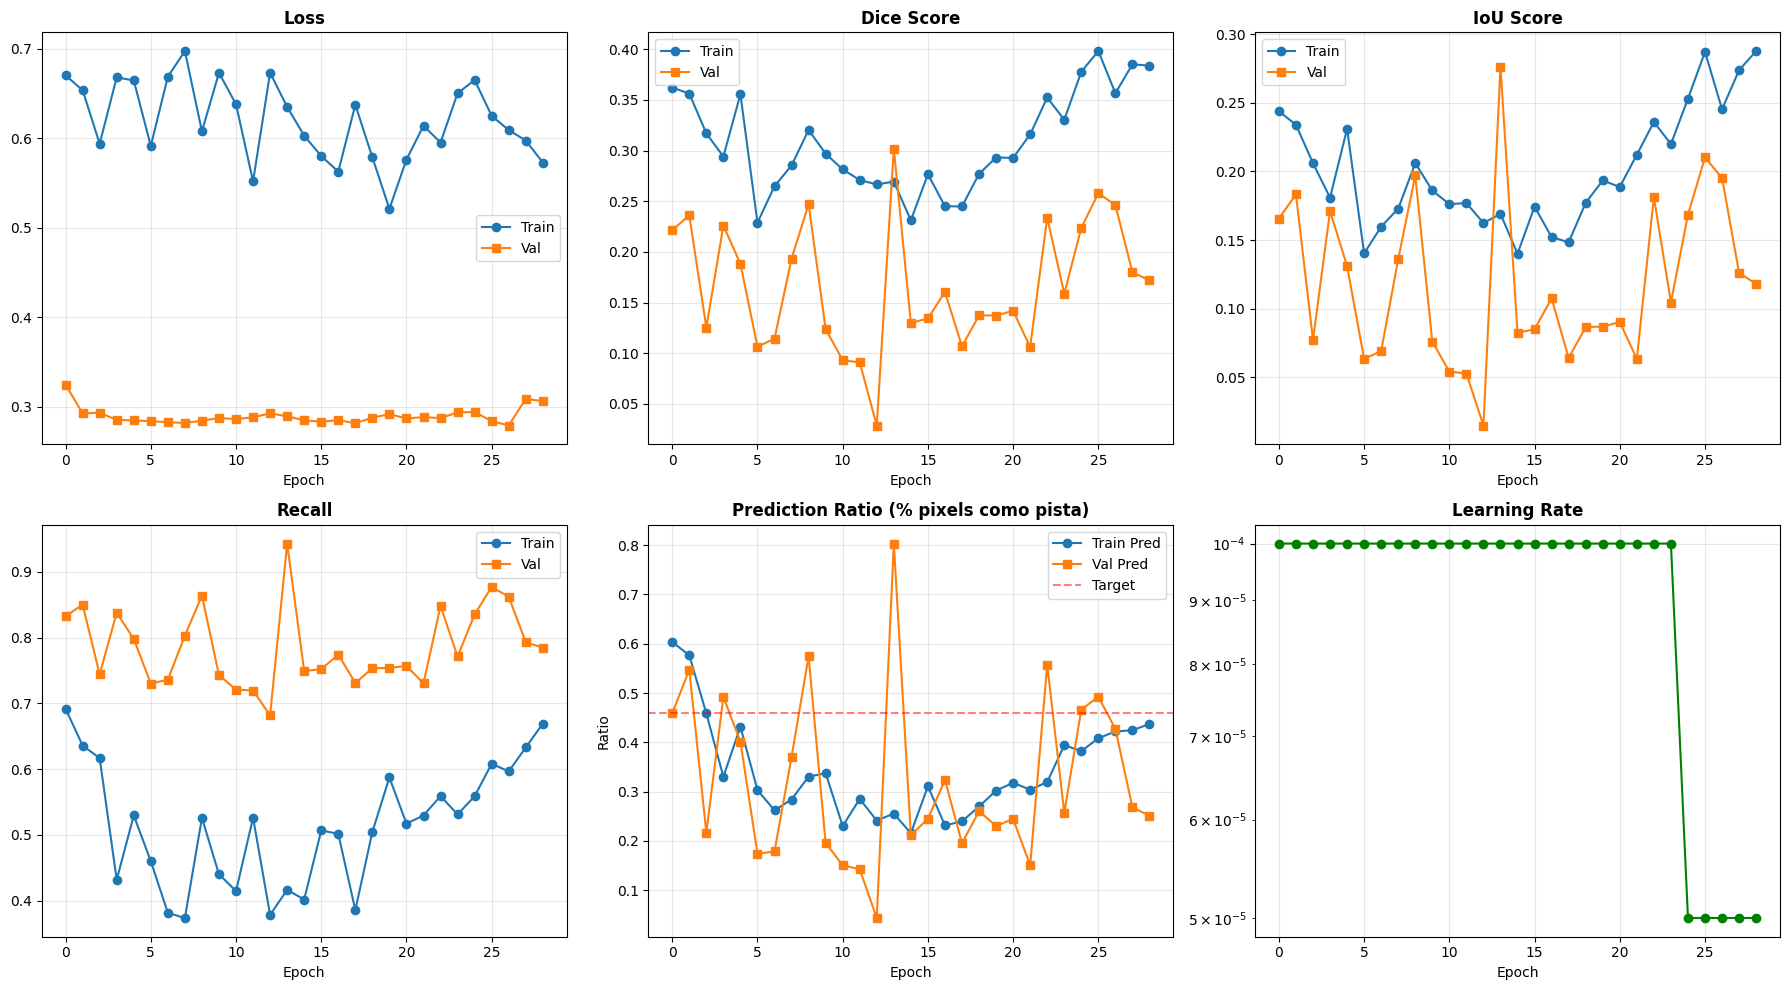


PRÓXIMOS PASSOS:
1. Verificar os gráficos de 'Prediction Ratio'
2. Se pred_ratio ≈ true_ratio → modelo está balanceado ✓
3. Carregar melhor modelo e visualizar resultados:

   model.load_state_dict(torch.load('best_runway_model_fixed.pth'))
   visualize_results(patch_path, model)


In [25]:
# Configuração
#DATA_DIR = '/content/drive/MyDrive/S2_patches'
BATCH_SIZE = 4
N_EPOCHS = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Dados
train_files = glob.glob(DATA_DIR + '/train/*.tif')
val_files = glob.glob(DATA_DIR + '/val/*.tif')

print(f"Train: {len(train_files)}, Val: {len(val_files)}")

train_ds = PatchDataset(train_files, augment=True)
val_ds = PatchDataset(val_files, augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


#MODELO
model = smp.Unet(
  encoder_name="mit_b2",
  encoder_weights=None,
  in_channels=8,
  classes=1
)
model = model.to(device)

print("\n✓ Modelo criado: MiT-B2 U-Net (8 canais, sem pre-training)")

# Optimizer (Adam simples, funciona bem)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Scheduler
scheduler = ReduceLROnPlateau(
  optimizer,
  mode='max',
  factor=0.5,
  patience=10,
  min_lr=1e-6
)

print("✓ Optimizer: Adam (lr=1e-4)")
print("✓ Scheduler: ReduceLROnPlateau (patience=7)")
print("✓ Loss: Dice + Focal")

# Treinar
print("\nIniciando treinamento...")
history = train_model(
  model=model,
  train_dl=train_dl,
  val_dl=val_dl,
  criterion=criterion,
  optimizer=optimizer,
  scheduler=scheduler,
  n_epochs=N_EPOCHS,
  device=device,
  save_path='best_runway_model_fixed.pth'
)

# Plotar
plot_history(history)

print("\n" + "="*70)
print("PRÓXIMOS PASSOS:")
print("="*70)
print("1. Verificar os gráficos de 'Prediction Ratio'")
print("2. Se pred_ratio ≈ true_ratio → modelo está balanceado ✓")
print("3. Carregar melhor modelo e visualizar resultados:")
print()
print("   model.load_state_dict(torch.load('best_runway_model_fixed.pth'))")
print("   visualize_results(patch_path, model)")
print("="*70)

VISUALIZAR RESULTADOS

In [37]:
myMOdel = model.load_state_dict(torch.load('best_runway_model_fixed.pth'))
patch_path = DATA_DIR + '/val/patch_runway_50.tif'

visualize_results(patch_path, model)

TypeError: binary_opening() got an unexpected keyword argument 'structure'

RODAR MODELO NO SUDOESTE DO PARÁ

In [ ]:
# Definir região (sudoeste do Pará - exemplo aproximado)
sudoeste = ee.Geometry.Polygon(
        [[[-52.59613841351879, -6.356783660086396],
          [-49.53139991911596, -4.1783899397969275],
          [-50.80598796677149, -3.2356036897198157],
          [-51.981646456329756, -2.3468091876791863],
          [-52.82415797738518, -2.666002061317475],
          [-55.15338003304118, -4.179507232248292],
          [-56.88401724358476, -3.4980446511415733],
          [-58.264167624420864, -6.472092530381011],
          [-58.39189266335144, -6.489137552713428],
          [-58.48312523993456, -6.66157339391492],
          [-58.50848282647474, -6.850370490054427],
          [-58.32116101917348, -7.0813813664840985],
          [-58.18305487714016, -7.421333170394046],
          [-58.013928854262865, -7.548258831740347],
          [-57.86107006324287, -7.980021884800475],
          [-57.60403620768598, -8.76695341287983],
          [-57.486903027374126, -8.785864823966355],
          [-57.43291865830161, -8.864470269651912],
          [-57.220427871552616, -8.965931706383422],
          [-57.09348147150538, -9.079017585255384],
          [-57.05920840339714, -9.220539857425926],
          [-56.89857928220598, -9.321853555562422],
          [-56.76454136759605, -9.423836790332489],
          [-56.660698026938014, -9.374030990177522],
          [-56.31023861879713, -9.397560736591272],
          [-55.68342537336057, -9.452003914837505],
          [-54.5228504531194, -9.544480614217953],
          [-52.20570739868281, -9.709751455971016]]]);

test_region = ee.Geometry.Polygon(
        [[[-55.38383611175692, -3.543724422123827],
          [-56.676331067560845, -3.8918345254310633],
          [-56.46209763626444, -4.847601405015175],
          [-55.151061772419375, -4.549839344065947]]]);

test_region2 = ee.Geometry.Polygon(
        [[[-56.812878305424334, -7.691799950329149],
          [-56.62130420874465, -7.662538847636999],
          [-56.64877002905715, -7.4576552502494735],
          [-56.8218046970259, -7.478079889634685]]]);

roi = test_region2

# --- CONFIGURAÇÕES DE ESCALA E GRID ---
# 0.09 graus é aprox. 10km (1000 pixels de 10m)
# Isso vai reduzir drasticamente o número de tiles e acelerar o processo
INTERVALO_GRAUS = 0.09

# Gerar o grid (Fishnet)
# 0.023 graus gera exatamente ~256 pixels de 10m
INTERVALO_TILE = 0.023

grid = geemap.fishnet(roi, h_interval=INTERVALO_TILE, v_interval=INTERVALO_TILE)
features = grid.getInfo()['features']
print(f"Total de tiles: {len(features)}")

# --- FUNÇÕES CORRIGIDAS ---

def mask_s2_clouds(image):
  qa = image.select('QA60')
  cloud_bit_mask = 1 << 10
  cirrus_bit_mask = 1 << 11
  mask = qa.bitwiseAnd(cloud_bit_mask).eq(0).And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
  # Mantemos o divide(10000) aqui para converter de Inteiro para Float (0-1)
  return image.updateMask(mask).divide(10000)

def get_s2_image_per_tile(tile_geom):
  # Dataset Sentinel-2 Harmonized (SR)
  dataset = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
      .filterDate('2025-07-01', '2025-09-30') \
      .filterBounds(tile_geom) \
      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

  if dataset.size().getInfo() == 0:
      return None

  # 1. Mediana e Divisão por 10000 (conforme seu maskS2clouds)
  composite = dataset.median().divide(10000)

  # 2. Seleção das Bandas Base (Mesma ordem do GEE)
  baseBands = composite.select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12'])

  # 3. Cálculo do NDVI e NDBI
  ndvi = composite.normalizedDifference(['B8', 'B4']).rename('NDVI')
  ndbi = composite.normalizedDifference(['B11', 'B8']).rename('NDBI')


  # Transforma -1 a 1 em 0 a 1
  ndvi = ndvi.add(1).divide(2).rename('NDVI')
  ndbi = ndbi.add(1).divide(2).rename('NDBI')

  # 4. Empilhamento Final (Exatamente 8 bandas)
  finalImage = baseBands.addBands(ndvi).addBands(ndbi)

  # 5. Forçar Projeção e Escala (Para evitar distorção de pixel)
  return finalImage.clip(tile_geom).reproject(crs='EPSG:4326', scale=10)

  # Mosaico costuma ser mais rápido que mediana para grandes áreas
  s2_tile = s2_col.median().clip(region)

  ndvi = s2_tile.normalizedDifference(['B8', 'B4']).rename('ndvi')
  ndbi = s2_tile.normalizedDifference(['B11', 'B8']).rename('ndbi')

  return s2_tile.select(['B4', 'B3', 'B2', 'B8', 'B11', 'B12']).addBands([ndvi, ndbi])


def mask_to_polygons(mask, bbox, roi_geometria):
  """
  Converte a máscara em polígonos e filtra o que está fora da ROI.
  """
  # Define a resolução baseada no bbox e tamanho da máscara
  res_x = (bbox[2] - bbox[0]) / mask.shape[1]
  res_y = (bbox[3] - bbox[1]) / mask.shape[0]

  # Cria a transformada afim (mapeia pixels para coordenadas geográficas)
  transform = rasterio.transform.from_origin(bbox[0], bbox[3], res_x, res_y)

  # Vetoriza a máscara (apenas os pixels 1)
  shapes = rasterio.features.shapes(mask, mask=mask.astype(bool), transform=transform)

  valid_polys = []
  for geom, value in shapes:
      poly_shape = shape(geom)

      # FILTRO: Verifica se a detecção toca a sua área de interesse (ROI)
      if poly_shape.intersects(roi_geometria):
          # Corta o polígono para ficar exatamente dentro da borda da ROI
          cortado = poly_shape.intersection(roi_geometria)
          if not cortado.is_empty:
              valid_polys.append(cortado)

  return valid_polys


INTERVALO_GRAUS = 0.023

output_file = "deteccoes_pistas_amazonia_limpo.geojson"
detected_runways = []
# Converter a ROI do GEE para Shapely uma única vez para o filtro
roi_shapely = shape(roi.getInfo())

print("Iniciando processamento com filtros de máscara...")

import cv2 # Para garantir o redimensionamento

for i, feat in enumerate(features):
  tile_geom = feat['geometry']
  current_tile_img = get_s2_image_per_tile(tile_geom)

  if current_tile_img is None: continue

  print(f'rodando no tile: {i}')

  try:
      # Puxa os dados
      patch = geemap.ee_to_numpy(
          current_tile_img,
          region=tile_geom,
          scale=10
      )

      # Garante o tamanho 256x256 que o modelo espera
      if patch.shape[0] != 256 or patch.shape[1] != 256:
          patch = cv2.resize(patch, (256, 256))

      #NORMALIZACAO
      if np.nanmax(patch) > 10:
          patch = patch / 10000.0

      # O ee_to_numpy pode retornar NaNs onde há nuvens ou bordas
      patch = np.nan_to_num(patch, nan=0.0, posinf=1.0, neginf=0.0)

      # Converte para Tensor (Batch, Channels, Height, Width)
      input_tensor = torch.from_numpy(patch).permute(2, 0, 1).float().unsqueeze(0).to(device)

      with torch.no_grad():
          output = model(input_tensor)
          probs = torch.sigmoid(output)

          max_p = probs.max().item()

          # Se a probabilidade for alta, processamos
          if max_p > 0.65: # Threshold calibrado com seu log anterior
              mask = (probs > 0.55).cpu().numpy().astype(np.uint8)[0][0]

              coords = tile_geom['coordinates'][0]
              lons, lats = [c[0] for c in coords], [c[1] for c in coords]
              bbox = [min(lons), min(lats), max(lons), max(lats)]

              polys = mask_to_polygons(mask, bbox, roi_shapely)
              if polys:
                  detected_runways.extend(polys)
                  print(f"✨ Sucesso! {len(polys)} pista(s) no tile {i} (Confiança: {max_p:.2f})")
          else:
              if i % 10 == 0: print(f"Tile {i} processado. Max prob: {max_p:.4f}")

  except Exception as e:
      print(f"Erro no tile {i}: {e}")

  # Salva no Drive/Colab a cada 50 tiles para não perder progresso
  if i % 50 == 0 and detected_runways:
      gdf = gpd.GeoDataFrame({'geometry': detected_runways}, crs="EPSG:4326")
      gdf.to_file(output_file, driver='GeoJSON')

# Resultado Final
if detected_runways:
  final_gdf = gpd.GeoDataFrame({'geometry': detected_runways}, crs="EPSG:4326")
  final_gdf.to_file(output_file, driver='GeoJSON')
  print("Processamento concluído com sucesso!")

In [ ]:
print(f"Total de polígonos detectados: {len(detected_runways)}")

In [ ]:
import geemap


Map = geemap.Map()
Map.centerObject(roi, 13)

# Adicionar Satélite de alta resolução para conferir
Map.add_tile_layer('https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
                   name='Google Satellite', attribution='Google')

if len(detected_runways) > 0:
    # Criar o GeoDataFrame para visualização
    gdf_teste = gpd.GeoDataFrame({'geometry': detected_runways}, crs="EPSG:4326")

    # Adicionar ao mapa em Amarelo para destacar
    Map.add_gdf(gdf_teste, layer_name="Deteccoes",
                style={'color': 'yellow', 'fillColor': '00000000', 'width': 3})
    print("Pistas plotadas no mapa abaixo.")
else:
    print("Nenhuma pista encontrada no teste.")

display(Map)

In [ ]:
import matplotlib.pyplot as plt

# Pegue apenas o primeiro tile para teste

tile = 18

test_feat = features[tile]['geometry']
img_teste = get_s2_image_per_tile(test_feat)
patch_teste = geemap.ee_to_numpy(img_teste, region=test_feat, scale=10)
patch_teste = cv2.resize(patch_teste, (256, 256))

print(f"Valores Máximos: {np.nanmax(patch_teste)}")
print(f"Valores Mínimos: {np.nanmin(patch_teste)}")
print(f"Shape: {patch_teste.shape}")

# Visualizar as bandas
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(patch_teste[:,:,:3] * 3) # RGB (multiplicado por 3 para brilho)
ax[0].set_title("Visão RGB (B4, B3, B2)")
ax[1].imshow(patch_teste[:,:,6], cmap='RdYlGn')
ax[1].set_title("Banda NDVI")
ax[2].imshow(patch_teste[:,:,7], cmap='coolwarm')
ax[2].set_title("Banda NDBI")
plt.show()

#REFERENCIAS

- Xie, E., Wang, W., Yu, Z., Anandkumar, A., Alvarez, J. M., & Luo, P. (2021). SegFormer: Simple and efficient design for semantic segmentation with transformers. arXiv preprint arXiv:2105.15203. https://arxiv.org/abs/2105.15203

- Google Earth Engine Data Catalog. (n.d.). Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (SR). European Union/ESA/Copernicus.
https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

- Iakubovskii, P. (2019). Segmentation Models PyTorch. GitHub repository. https://github.com/qubvel/segmentation_models.pytorch